# PhysCAL: Simulation Study

In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from doe import lhd
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from itertools import product
from strategy_lib import physcal_integrate, segp

%matplotlib inline
warnings.filterwarnings('ignore')

### Experiment Setting

In [2]:
# define the target process
def f(x):
    return abs((x[:, 0]-0.5) * (x[:, 1]-0.5))

# define the failure process
def h(x):
    return np.square(np.cos(2 * np.pi * x[:, 0]) - np.cos(2 * np.pi * x[:, 1])) - np.square(x[:, 0]-0.5) * np.square(x[:, 1]-0.5)

In [3]:
# ground truth (xi : failure threshold)
XX = np.array(list(product(np.linspace(0, 1, 50), np.linspace(0, 1, 50))))
X1, X2 = XX[:, 0].reshape(50, 50), XX[:, 1].reshape(50, 50)
YY = f(XX)
ZZ = h(XX)
xi = .7
print('Failure Region Ratio: %.3f' %(np.count_nonzero(ZZ >= xi) / len(XX)))

# store safe samples for evaluation
X_test = XX[ZZ < xi]
y_test = YY[ZZ < xi]

Failure Region Ratio: 0.445


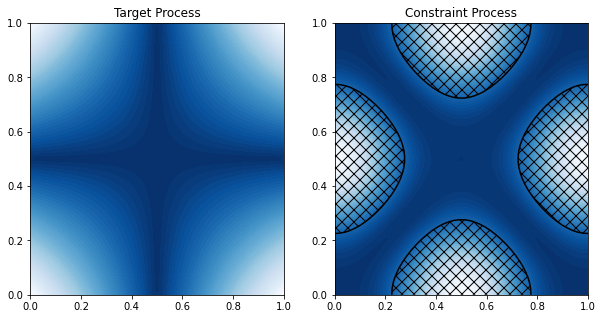

In [4]:
# visualize the ground truth
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].contourf(X1, X2, YY.reshape(50, 50), 50, cmap='Blues_r')
ax[0].set_title('Target Process')
ax[1].contourf(X1, X2, ZZ.reshape(50, 50), 50, cmap='Blues_r')
ax[1].contour(X1, X2, ZZ.reshape(50, 50), colors='k', levels=[-np.inf, xi, np.inf])
ax[1].contourf(X1, X2, ZZ.reshape(50, 50), colors='none', levels=[-np.inf, xi, np.inf], hatches=[None, 'xx'])
ax[1].set_title('Constraint Process')
plt.show()

In [5]:
# experiment setting
n0 = 10
n_max = 30
budget = n_max - n0
n_rep = 10

# default GP
kernel = ConstantKernel() * RBF()
f_physcal = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=0)
f_segp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=0)
h_physcal = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=0)
h_segp = GaussianProcessClassifier(kernel=kernel, n_restarts_optimizer=10, random_state=0)
# initial dataset using Latin Hypercube Design
X_init = lhd(n0, 2, criterion='maximin', seed=1234)
y_init = f(X_init)
z_init = h(X_init)
c_init = np.array(z_init >= xi, dtype=int)

# initial training
f_physcal.fit(X_init, y_init)
f_segp.fit(X_init, y_init)
h_physcal.fit(X_init, z_init)
h_segp.fit(X_init, c_init)

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1),
                          n_restarts_optimizer=10, random_state=0)

In [6]:
# active learning
X_physcal = X_init.copy()
y_physcal = y_init.copy()
z_physcal = z_init.copy()

w = [0.5]
for  i in range(budget):
    score_physcal, score_mat = physcal_integrate(XX, f_physcal, h_physcal, xi, alpha=1.96, weight=w[-1])
    x_new = np.atleast_2d(XX[np.argmax(score_physcal)])
    y_new = f(x_new)
    z_new = h(x_new)
    X_physcal = np.vstack((X_physcal, x_new))
    y_physcal = np.hstack((y_physcal, y_new))
    z_physcal = np.hstack((z_physcal, z_new))
    f_physcal.fit(X_physcal, y_physcal)
    h_physcal.fit(X_physcal, z_physcal)
    w.append(score_mat[:, 1].mean() / score_mat.mean(0).sum())

In [7]:
# active learning
X_segp = X_init.copy()
y_segp = y_init.copy()
z_segp = z_init.copy()
c_segp = c_init.copy()

for  i in range(budget):
    score_segp = segp(XX, f_segp, h_segp)
    x_new = np.atleast_2d(XX[np.argmax(score_segp)])
    y_new = f(x_new)
    z_new = h(x_new)
    c_new = np.array(h(x_new) >= xi, dtype=int)
    X_segp = np.vstack((X_segp, x_new))
    y_segp = np.hstack((y_segp, y_new))
    z_segp = np.hstack((z_segp, z_new))
    c_segp = np.hstack((c_segp, c_new))
    f_segp.fit(X_segp, y_segp)
    h_segp.fit(X_segp, c_segp)

In [8]:
# count total number of failures
n_fail_physcal = np.count_nonzero(z_physcal[n0:] >= xi)
n_fail_segp = np.count_nonzero(z_segp[n0:] >= xi)
# print the results
print('PhysCAL Additional Failures: %d' %n_fail_physcal)
print('SEGP Additional Failures: %d' %n_fail_segp)

PhysCAL Additional Failures: 0
SEGP Additional Failures: 9


In [9]:
ZZ_physcal = h_physcal.predict(XX)
ZZ_segp = h_segp.predict(XX)

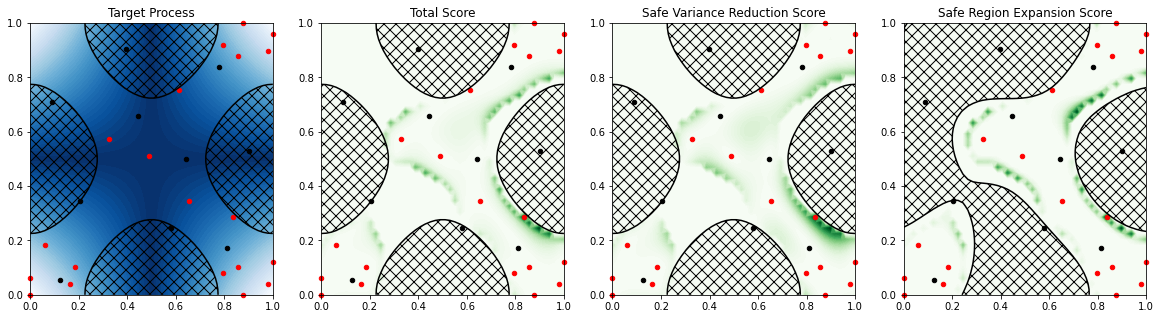

In [10]:
# visualize the result
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].set_title('Target Process')
ax[0].contourf(X1, X2, YY.reshape(50, 50), 50, cmap='Blues_r')
ax[0].scatter(X_init[:, 0], X_init[:, 1], c='k', s=20, clip_on=False)
ax[0].scatter(X_physcal[n0:, 0], X_physcal[n0:, 1], c='r', s=20, clip_on=False)
ax[0].contour(X1, X2, ZZ.reshape(50, 50), colors='k', levels=[-np.inf, xi, np.inf])
ax[0].contourf(X1, X2, ZZ.reshape(50, 50), colors='none', levels=[-np.inf, xi, np.inf], hatches=[None, 'xx'])

ax[1].set_title('Total Score')
ax[1].contourf(X1, X2, score_physcal.reshape(50, 50), 50, cmap='Greens')
ax[1].scatter(X_init[:, 0], X_init[:, 1], c='k', s=20, clip_on=False)
ax[1].scatter(X_physcal[n0:, 0], X_physcal[n0:, 1], c='r', s=20, clip_on=False)
ax[1].contour(X1, X2, ZZ.reshape(50, 50), colors='k', levels=[-np.inf, xi, np.inf])
ax[1].contourf(X1, X2, ZZ.reshape(50, 50), colors='none', levels=[-np.inf, xi, np.inf], hatches=[None, 'xx'])

ax[2].set_title('Safe Variance Reduction Score')
ax[2].contourf(X1, X2, score_mat[:, 0].reshape(50, 50), 50, cmap='Greens')
ax[2].scatter(X_init[:, 0], X_init[:, 1], c='k', s=20, clip_on=False)
ax[2].scatter(X_physcal[n0:, 0], X_physcal[n0:, 1], c='r', s=20, clip_on=False)
ax[2].contour(X1, X2, ZZ.reshape(50, 50), colors='k', levels=[-np.inf, xi, np.inf])
ax[2].contourf(X1, X2, ZZ.reshape(50, 50), colors='none', levels=[-np.inf, xi, np.inf], hatches=[None, 'xx'])

ax[3].set_title('Safe Region Expansion Score')
ax[3].contourf(X1, X2, score_mat[:, 1].reshape(50, 50), 50, cmap='Greens')
ax[3].scatter(X_init[:, 0], X_init[:, 1], c='k', s=20, clip_on=False)
ax[3].scatter(X_physcal[n0:, 0], X_physcal[n0:, 1], c='r', s=20, clip_on=False)
ax[3].contour(X1, X2, ZZ_physcal.reshape(50, 50), colors='k', levels=[-np.inf, xi, np.inf])
ax[3].contourf(X1, X2, ZZ_physcal.reshape(50, 50), colors='none', levels=[-np.inf, xi, np.inf], hatches=[None, 'xx'])
plt.show()

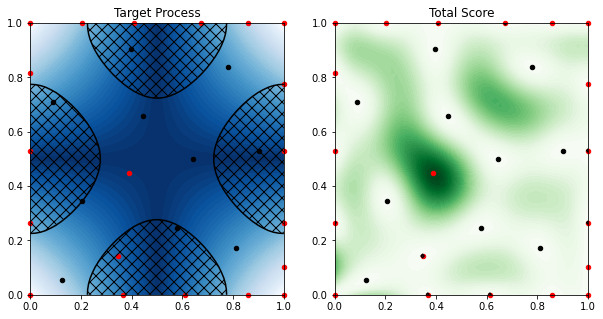

In [11]:
# visualize the result
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Target Process')
ax[0].contourf(X1, X2, YY.reshape(50, 50), 50, cmap='Blues_r')
ax[0].scatter(X_init[:, 0], X_init[:, 1], c='k', s=20, clip_on=False)
ax[0].scatter(X_segp[n0:, 0], X_segp[n0:, 1], c='r', s=20, clip_on=False)
ax[0].contour(X1, X2, ZZ.reshape(50, 50), colors='k', levels=[-np.inf, xi, np.inf])
ax[0].contourf(X1, X2, ZZ.reshape(50, 50), colors='none', levels=[-np.inf, xi, np.inf], hatches=[None, 'xx'])

ax[1].set_title('Total Score')
ax[1].contourf(X1, X2, score_segp.reshape(50, 50), 50, cmap='Greens')
ax[1].scatter(X_init[:, 0], X_init[:, 1], c='k', s=20, clip_on=False)
ax[1].scatter(X_segp[n0:, 0], X_segp[n0:, 1], c='r', s=20, clip_on=False)
ax[1].contour(X1, X2, ZZ_segp.reshape(50, 50), colors='k', levels=[-np.inf, xi, np.inf])
ax[1].contourf(X1, X2, ZZ_segp.reshape(50, 50), colors='none', levels=[-np.inf, xi, np.inf], hatches=[None, 'xx'])
plt.show()